In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [ ]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output files/dirs
MUTATION_DENSITY_FRACTION_RESULTS = "../results/mutation_density_fractions"
MUTATION_DENSITY_GENIC_REGIONS = "../results/mutation_density_genic_regions"

if not os.path.exists(MUTATION_DENSITY_FRACTION_RESULTS):
    os.makedirs(MUTATION_DENSITY_FRACTION_RESULTS)
if not os.path.exists(MUTATION_DENSITY_GENIC_REGIONS):
    os.makedirs(MUTATION_DENSITY_GENIC_REGIONS)

In [37]:
cancer_type = "Liver-HCC"

In [ ]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

In [38]:
# get all mutations in driver genes
mut_df = pd.read_csv(os.path.join(ANNOTATED_MUTATIONS, cancer_type + ".tsv"), sep="\t")
driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
driver_genes_list = driver_genes["gene"].tolist()
mut_df = mut_df[mut_df["gene"].isin(driver_genes_list)]
mut_df = pd.merge(mut_df, driver_genes, on="gene", how="left")
mut_df.head()

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,exon_length,intron_length,3UTR_length,5UTR_length,start_codon_length,stop_codon_length,transcript_length,CDS_length,total_length,promoter_length
0,ARID1A,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:27077925-27077925:A:G,1:27077925:A:G,False,None,False,...,8595,78146,1348,389,3,3,86090,6855,86072,2501
1,SETDB1,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150909417-150909417:A:G,1:150909417:A:G,False,mutational,True,...,4716,34132,531,252,3,6,38475,3927,38475,2501
2,SETDB1,+,Missense_Mutation,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150933317-150933317:A:C,1:150933317:A:C,True,mutational,True,...,4716,34132,531,252,3,6,38475,3927,38475,2501
3,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46151744-46151744:A:T,12:46151744:A:T,False,None,False,...,8793,169734,3150,131,3,6,178332,5506,178376,2501
4,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46259757-46259757:T:G,12:46259757:T:G,False,None,False,...,8793,169734,3150,131,3,6,178332,5506,178376,2501


In [ ]:
print(mut_df.shape)
# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

In [39]:
print(mut_df["genic_region"].value_counts())
mut_df["genic_region"] = mut_df["genic_region"].replace({
    "ncRNA_exonic": "ncRNA",
    "ncRNA_intronic": "ncRNA"
})
regions = ["UTR5", "UTR3", "ncRNA", "exonic", "intronic", "splicing", "upstream", "downstream"]
mut_df["genic_region"] = mut_df["genic_region"].apply(lambda x: x if x in regions else "-")
mut_df["genic_region"].value_counts()

intronic          5613
exonic             392
ncRNA_intronic      80
intergenic          69
splicing            20
UTR3                16
ncRNA_exonic        14
downstream          10
upstream             8
UTR5                 4
Name: genic_region, dtype: int64


intronic      5613
exonic         392
ncRNA           94
-               69
splicing        20
UTR3            16
downstream      10
upstream         8
UTR5             4
Name: genic_region, dtype: int64

In [40]:
region_length_map = {
    "intronic": "intron_length",
    "exonic": "exon_length",
    "UTR3": "3UTR_length",
    "UTR5": "5UTR_length"
}

def get_region_length(row):
	if row["genic_region"] in region_length_map:
		return row[region_length_map[row["genic_region"]]]
	elif row["genic_region"] == "upstream" or row["genic_region"] == "downstream":
		return 1000
	elif row["genic_region"] == "splicing" or row["genic_region"] == "ncRNA":
		return 1 # regions not well defined

mut_df["region_length"] = mut_df.apply(get_region_length, axis=1)
mut_df.head()

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,intron_length,3UTR_length,5UTR_length,start_codon_length,stop_codon_length,transcript_length,CDS_length,total_length,promoter_length,region_length
0,ARID1A,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:27077925-27077925:A:G,1:27077925:A:G,False,None,False,...,78146,1348,389,3,3,86090,6855,86072,2501,78146.0
1,SETDB1,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150909417-150909417:A:G,1:150909417:A:G,False,mutational,True,...,34132,531,252,3,6,38475,3927,38475,2501,34132.0
2,SETDB1,+,Missense_Mutation,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,1:150933317-150933317:A:C,1:150933317:A:C,True,mutational,True,...,34132,531,252,3,6,38475,3927,38475,2501,4716.0
3,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46151744-46151744:A:T,12:46151744:A:T,False,None,False,...,169734,3150,131,3,6,178332,5506,178376,2501,169734.0
4,ARID2,+,Intron,0040b1b6-b07a-4b6e-90ef-133523eaf412,DO45049,12:46259757-46259757:T:G,12:46259757:T:G,False,None,False,...,169734,3150,131,3,6,178332,5506,178376,2501,169734.0


In [ ]:
# passenger density for each gene in each sample
passenger_density = mut_df.groupby(["Tumor_Sample_Barcode", "gene", "genic_region"]).agg({
    "driver": lambda x: x.value_counts().get(False, 0),
    "has_driver": "any", # driver mutation in any genic region of the gene
    "region_length": "first"
}).reset_index()
passenger_density = passenger_density.rename(columns={"driver": "passenger_density"})
# adjust for genome-wide mutation rate, cna burden
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
print(passenger_density.shape, genome_wide_mutations.shape)
passenger_density = pd.merge(passenger_density, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
passenger_density["cna_burden"] = passenger_density["cna_burden"] / 100 # convert from percentage to fraction
print(passenger_density.shape)
passenger_density["adj_passenger_density"] = passenger_density["passenger_density"] * 3.2e9 / (passenger_density["total_mutations"] * passenger_density["cna_burden"] * passenger_density["region_length"])
passenger_density = passenger_density[["Tumor_Sample_Barcode", "gene", "has_driver", "genic_region", "adj_passenger_density"]]
passenger_density.head()

(1504, 6) (2778, 5)
(1504, 10)


,Tumor_Sample_Barcode,gene,has_driver,genic_region,adj_passenger_density
0,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,intronic,0.883011
1,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,intronic,1.448980
2,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID2,False,intronic,1.334229
3,0040b1b6-b07a-4b6e-90ef-133523eaf412,CSMD3,False,intronic,1.036444
4,0040b1b6-b07a-4b6e-90ef-133523eaf412,CTNNB1,False,intronic,3.000159


In [42]:
driver_status = passenger_density[['Tumor_Sample_Barcode', 'gene', 'has_driver']].drop_duplicates()
driver_status = driver_status.set_index(['Tumor_Sample_Barcode', 'gene']).to_dict()['has_driver']
driver_status.items()

dict_items([(('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'APC'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'ARID1A'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'ARID2'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'CSMD3'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'CTNNB1'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'NFE2L2'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'RB1'), False), (('0040b1b6-b07a-4b6e-90ef-133523eaf412', 'SETDB1'), True), (('00c27940-c623-11e3-bf01-24c6515278c0', 'APC'), False), (('00c27940-c623-11e3-bf01-24c6515278c0', 'ARID1A'), False), (('00c27940-c623-11e3-bf01-24c6515278c0', 'ARID2'), False), (('00c27940-c623-11e3-bf01-24c6515278c0', 'CSMD3'), False), (('01dc6872-c623-11e3-bf01-24c6515278c0', 'CSMD3'), False), (('01dc6872-c623-11e3-bf01-24c6515278c0', 'CTNNB1'), True), (('030695f6-c623-11e3-bf01-24c6515278c0', 'CSMD3'), False), (('03c88506-d72e-4a44-a34e-a7f0564f1799', 'APC'), False), (('03c88506-d72e-4a44-a34e-a7f05

In [43]:
# add rows for samples with no mutations in driver genes
tumors = passenger_density["Tumor_Sample_Barcode"].unique()
for tumor in tumors:
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	for gene in driver_genes_list:
		for region in regions:
			if len(passenger_density[(passenger_density["Tumor_Sample_Barcode"] == tumor) & (passenger_density["gene"] == gene) & (passenger_density["genic_region"] == region)]) == 0:
				passenger_density = pd.concat([passenger_density, pd.DataFrame({
					"Tumor_Sample_Barcode": [tumor], 
					"gene": [gene], 
					"has_driver": [driver_status.get((tumor, gene), False)],
					"genic_region": [region],
					"adj_passenger_density": [0],
				})])
print(passenger_density.shape)
passenger_density.to_csv(f"{MUTATION_DENSITY_GENIC_REGIONS}/{cancer_type}.tsv", sep="\t", index=False)
passenger_density.head()

(31455, 5)


,Tumor_Sample_Barcode,gene,has_driver,genic_region,adj_passenger_density
0,0040b1b6-b07a-4b6e-90ef-133523eaf412,APC,False,intronic,0.883011
1,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID1A,False,intronic,1.448980
2,0040b1b6-b07a-4b6e-90ef-133523eaf412,ARID2,False,intronic,1.334229
3,0040b1b6-b07a-4b6e-90ef-133523eaf412,CSMD3,False,intronic,1.036444
4,0040b1b6-b07a-4b6e-90ef-133523eaf412,CTNNB1,False,intronic,3.000159


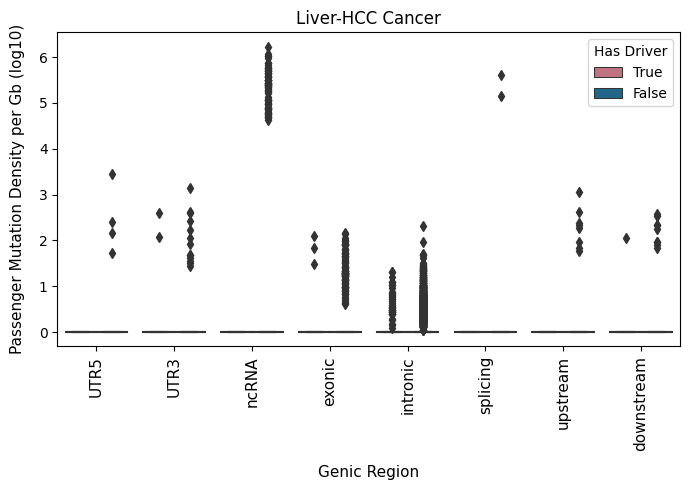

In [44]:
passenger_density["passenger_density_log"] = np.log10(passenger_density["adj_passenger_density"] + 1)
plt.figure(figsize=(7, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
sns.boxplot(
    x="genic_region",
	y="passenger_density_log",
	hue="has_driver",
	data=passenger_density,
    order=regions,
    hue_order=[True, False],
    palette=cmap,
)
plt.xlabel("Genic Region", fontsize=11, labelpad=10)
plt.xticks(rotation=90, fontsize=11)
plt.ylabel("Passenger Mutation Density per Gb (log10)", fontsize=11, labelpad=10)
plt.legend(title="Has Driver")
plt.title(f"{cancer_type} Cancer")
plt.tight_layout()
plt.savefig(f"{MUTATION_DENSITY_GENIC_REGIONS}/{cancer_type}.png", dpi=300)

In [45]:
# Average passenger mutation density in samples without driver mutations as a fraction of average passenger mutation density in all samples
passengers_genic_region = passenger_density.copy()
passengers_genic_region = passengers_genic_region.groupby(["has_driver", "genic_region"]).agg({
    "adj_passenger_density": "mean",
}).reset_index()
passengers_genic_region = passengers_genic_region.pivot(index="genic_region", columns="has_driver", values="adj_passenger_density").fillna(0)
if True not in passengers_genic_region.columns:
    passengers_genic_region[True] = 0
if False not in passengers_genic_region.columns:
    passengers_genic_region[False] = 0
passengers_genic_region["fraction"] = passengers_genic_region[False] / (passengers_genic_region[False] + passengers_genic_region[True])
passengers_genic_region.to_csv(f"{MUTATION_DENSITY_FRACTION_RESULTS}/{cancer_type}.tsv", sep="\t")
passengers_genic_region

has_driver,False,True,fraction
genic_region,,,
-,0.000000,0.000000,NaN
UTR3,0.839533,1.765008,0.322334
UTR5,0.903824,0.000000,1.000000
downstream,0.455509,0.384485,0.542277
exonic,0.765385,0.747792,0.505813
intronic,1.080579,0.655434,0.622448
ncRNA,6692.213760,0.000000,1.000000
splicing,149.500132,0.000000,1.000000
upstream,0.663315,0.000000,1.000000
